# Artificial Neural Networks for lignin pyrolysis
***
<img src="NNmodel2.jpg" width=500>
#### 4.29.16 Group Meeting  



# ANNs can bypass physics-based models to overcome limitations
---
- Mechanistic reaction-transport models, even if they existed, are too computationally expensive to use for process optimization


- With current experimental approaches we can't get the info needed for accurate particle models, but we can gather the info needed to train ANNs:
  * initial compositions and operating conditions, product yields and compositions


- ANNs can offer some of what we want from mechanistic models, but don't require mechanistic understanding.

  
- ANNs are algorithms for learning complex non-linear hypotheses and recognizing patterns

# nolearn creates a sklearn estimator for ANNs
---
- wrapper for Lasagne: the most widely used (and supported) python ANN package
- compatible with sklearn (use things like `gridsearch` and `preprocessing`)
- pip-installable, but use a virtual environment
- after training you can pickle the network to work with later

```python
net = NeuralNet(
            layers=[
                ('input', layers.InputLayer),
                ('hidden0', layers.DenseLayer),
                ('output', layers.DenseLayer)
                ],
            input_shape=(None, x_train.shape[1]),
            hidden0_num_units=22,
            hidden0_nonlinearity=nonlinearities.sigmoid,
            output_num_units=y_train.shape[1],
            output_nonlinearity=nonlinearities.linear,
            regression=True,
            # many other options: i.e. sgd, adagrad
            update=lasagne.updates.nesterov_momentum,
            update_momentum=0.9,
            update_learning_rate=0.9,
            verbose=1,
            max_epochs=1000,
            # can add regularization, or use dropout layers
            objective_l2=0.0001
            )
net.fit(x_train[:8000,:], y_train[:8000,:])
```

In [1]:
try:
    import cPickle as pickle
except:
    import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import lasagne
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# recreate the training and test sets.  I have tested this and confirmed
# that it always reproduces the same arrays

# specify the seed for random number generation so we can get consistent
# shuffling and initialized weights
np.random.seed(6509)

# Read the training data for the neural network
# Input data is 250000x4 and output data is 250000x32
X = pd.read_csv('../parameters_250000.txt', sep=' ')
Y = pd.read_csv('../results.txt', sep=' ', index_col=False)
# These functional groups do not exist in my model
Y = Y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)
y_columns = Y.columns.values

X = X.values.astype(np.float32)
Y = Y.values.astype(np.float32)

# Shuffle the dataset (because x parameters are varied in a structured way)
combined = np.concatenate((X, Y), axis=1)
np.random.shuffle(combined)

# Separate the data into training (with included validation) and test sets.
# (Validation set is separated from the training set by nolearn)
test_fraction = 0.2
training = combined[:-int(test_fraction * combined.shape[0]), :]
test = combined[-int(test_fraction * combined.shape[0]):, :]

x_train = training[:, :4]
y_train = training[:, 4:]
x_test = test[:, :4]
y_test = test[:, 4:]

# load the full trained network and related scaling objects
with open('ann_objects.pkl', 'rb') as pkl:
    net_objs = pickle.load(pkl)
comp_net = net_objs[0]
x_scaler = net_objs[1]
y_scaler = net_objs[2]

# Standardize the input parameters to have zero mean and unit variance
# x_scaler.transform() can be used later to transform any new data
# x_scaler.inverse_transform() can be used to get the original data back
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)

# Scale the output parameters to lie between 0 and 1
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

# load pickles
output_col_files = !ls ann_objects-*

# dictionary of nets for each output measure
net_objs = {}
for filename in output_col_files:
    output_col = int(filename.split('-')[1])
    with open(filename, 'rb') as pkl:
        net_objs[output_col] = pickle.load(pkl)[0]

# Training an ANN for the complete system

- 250,000 training examples from sensitivity analysis to use for train/validation/test sets


- Initially trained a network to predict all 30 of my output measures of interest at the same time


- Used `sklearn.grid_search.GridSearchCV` to identify best network architecture



```python
# Set up the gridsearch
param_grid = {'hidden0_num_units': range(4, 33),
              'update_momentum': [x/10.0 for x in range(1, 21)],
              'update_learning_rate': [x/10.0 for x in range(1, 21)]
              }
grid_search = GridSearchCV(net, param_grid, verbose=0, n_jobs=20,
                           pre_dispatch='2*n_jobs',
                           scoring='mean_squared_error')

grid_search.fit(x_train[:6000, :], y_train[:6000])

```

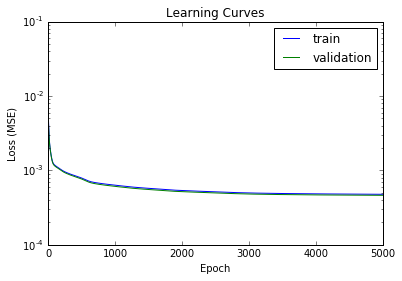

In [3]:
# Plot the learning curves for the complete network 
train_loss = np.array([i["train_loss"] for i in comp_net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in comp_net.train_history_])

plt.figure(1)
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.title('Learning Curves')

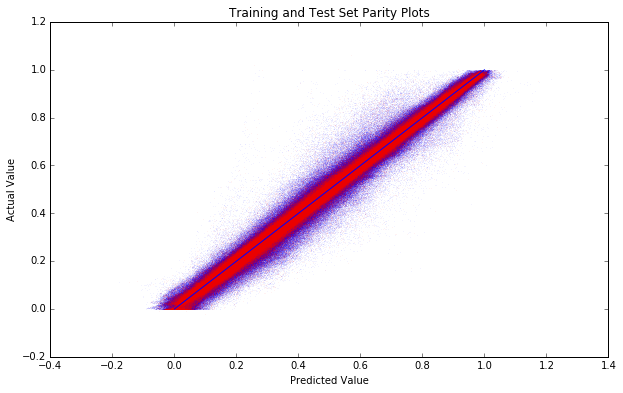

In [4]:
# Parity plot of the complete network training data
y_predictions = comp_net.predict(x_train)
y_predictions_test = comp_net.predict(x_test)
ub = y_predictions.shape[0]
plt.figure(2, figsize=(10, 6))
plt.scatter(y_predictions[:ub, :].flatten(), y_train[:ub, :].flatten(),
            s=0.1, alpha=0.05, c='b', marker='x', label='train')
plt.scatter(y_predictions_test[:ub, :].flatten(), y_test[:ub, :].flatten(),
           s=0.1, alpha=0.05, c='r', marker='x', label='test')
plt.plot([0, 1],[0, 1])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Training and Test Set Parity Plots')


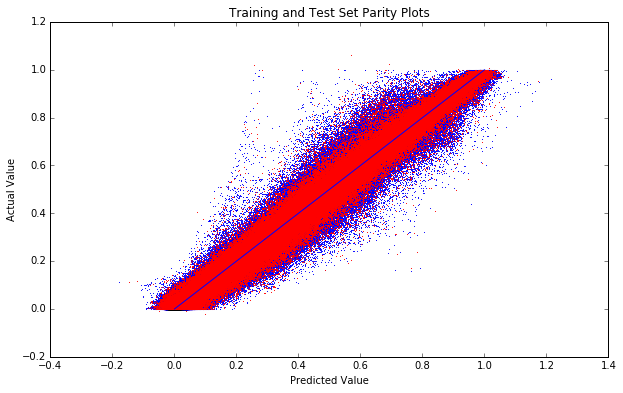

In [5]:
# NOTE: alpha trick
ub = y_predictions.shape[0]
plt.figure(2, figsize=(10, 6))
plt.scatter(y_predictions[:ub, :].flatten(), y_train[:ub, :].flatten(),
            s=0.1, alpha=1, c='b', marker='x',)
plt.scatter(y_predictions_test[:ub, :].flatten(), y_test[:ub, :].flatten(),
           s=0.1, alpha=1, c='r', marker='x',)
plt.plot([0, 1], [0, 1])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Training and Test Set Parity Plots')

In [6]:
def pplot_one_output(y_predictions, y_predictions_test, output_col, ub=None):
    """
    Make a parity plot for the training (blue) and test (red) set predictions
    of a specific output measure.
    
    Parameters
    ----------
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    output_col         : int
                         The column of the output measure you want to plot
    ub                 : int
                         The number of points you would like to include in plot
    
    Returns
    -------
    None
    """
    if ub is None:
        ub = y_predictions.shape[0]
    # Parity plot of the training data
    ax[output_col].scatter(y_predictions[:ub, output_col].flatten(),
                           y_train[:ub, output_col].flatten(),
                           s=0.1, alpha=0.16,
                           c='b', marker='x', label='train')
    ax[output_col].scatter(y_predictions_test[:ub, output_col].flatten(),
                           y_test[:ub, output_col].flatten(),
                           s=0.1, alpha=0.16,
                           c='r', marker='x', label='test')
    ax[output_col].plot([0, 1], [0, 1], c='black')
    ax[output_col].set_title('%s' % y_columns[output_col])
    ax[output_col].set_xlim([-0.1, 1.1]) 
    ax[output_col].set_ylim([-0.1, 1.1])

    

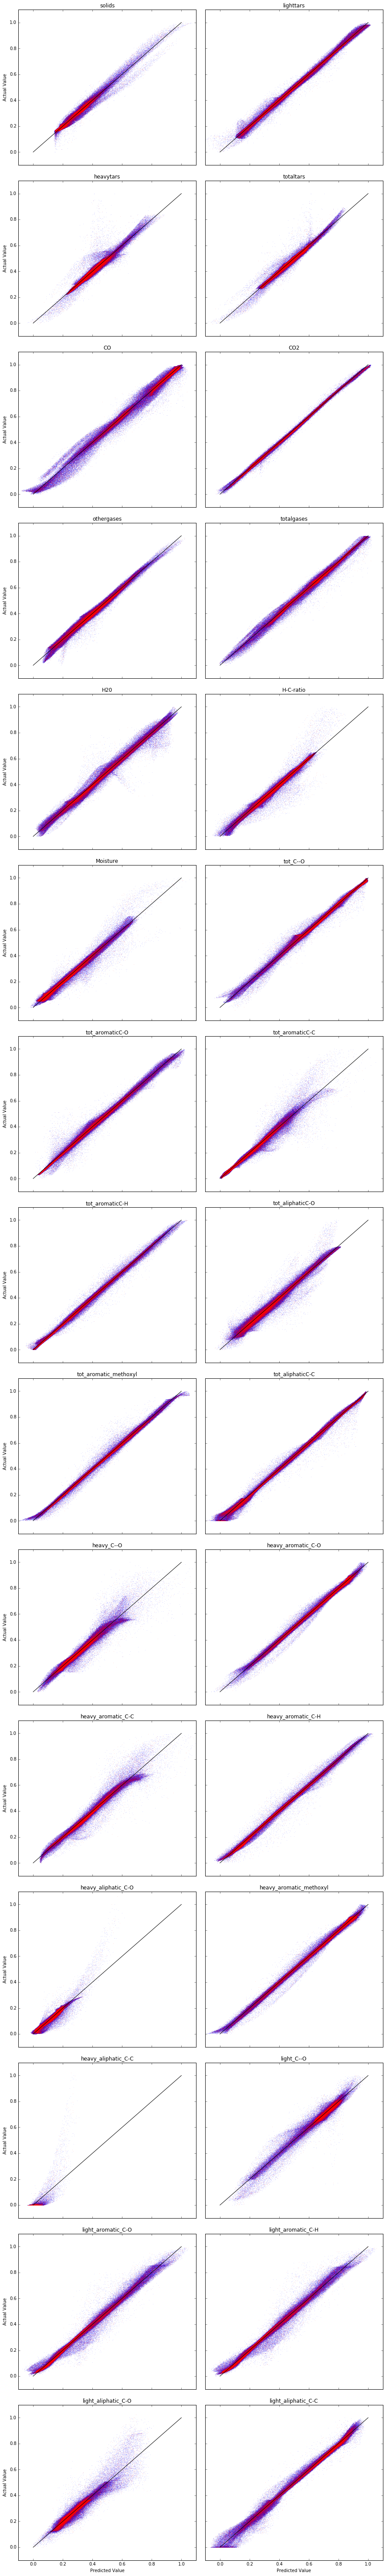

In [7]:
# Plot contributions from each output measure
output_list = y_columns[:]
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=True,
                     sharey=True, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()
for i, x in enumerate(output_list):
    pplot_one_output(y_predictions, y_predictions_test, i)
ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.05)
    

In [10]:
r_squared = {}
for i, x in enumerate(output_list):
    r_squared[x] = r2_score(y_train[:, i], y_predictions[:, i])
r_squared

{'CO': 0.9872102407920309,
 'CO2': 0.99831477413535497,
 'H-C-ratio': 0.9732516480103286,
 'H20': 0.98567867801781484,
 'Moisture': 0.97730880509188678,
 'heavy_C--O': 0.94965443783355818,
 'heavy_aliphatic_C-C': 0.5141602203690655,
 'heavy_aliphatic_C-O': 0.91558716754200464,
 'heavy_aromatic_C-C': 0.96630852705452674,
 'heavy_aromatic_C-H': 0.99470281850191311,
 'heavy_aromatic_C-O': 0.99402432722151524,
 'heavy_aromatic_methoxyl': 0.99520844915151874,
 'heavytars': 0.95001552630398556,
 'light_C--O': 0.96602829227486653,
 'light_aliphatic_C-C': 0.99157157448631117,
 'light_aliphatic_C-O': 0.91578965066153284,
 'light_aromatic_C-H': 0.9871394913172904,
 'light_aromatic_C-O': 0.98785505529812678,
 'lighttars': 0.9948038509603061,
 'othergases': 0.98692273319671409,
 'solids': 0.97849898925493739,
 'tot_C--O': 0.99359257437137716,
 'tot_aliphaticC-C': 0.9957859524363305,
 'tot_aliphaticC-O': 0.97260221137497493,
 'tot_aromaticC-C': 0.96461247283311291,
 'tot_aromaticC-H': 0.99585304850

# Training independent networks for each of the 30 output measures

- Address compromised fits for outputs by training individual networks


- Repeat gridsearch again to get best architecture for each network


- Found that a different update algorithm works better for individual output networks...

In [11]:
def pplot_one_output(y_predictions, y_predictions_test, output_col, title,
                     ub=None):
    """
    Make a parity plot for the training (blue) and test (red) set predictions
    of a specific output measure.
    
    Parameters
    ----------
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    title              : string
                         The name of the output measure being plotted
    ub                 : int
                         The number of points you would like to include in plot
    
    Returns
    -------
    None
    """
    if ub is None:
        ub = y_predictions.shape[0]

    # Parity plot of the training data
    ax[output_col].scatter(y_predictions[:ub].flatten(),
                           y_train[:ub, output_col].flatten(),
                           s=0.1, alpha=0.16,
                           c='b', marker='x', label='train')
    ax[output_col].plot([0, 1], [0, 1], c='black')
    ax[output_col].scatter(y_predictions_test[:ub].flatten(),
                           y_test[:ub, output_col].flatten(),
                           s=0.1, alpha=0.16,
                           c='r', marker='x', label='test')
    ax[output_col].set_title('%s' % title)
    ax[output_col].set_xlim([-0.1, 1.1]) 
    ax[output_col].set_ylim([-0.1, 1.1])
    
    return None


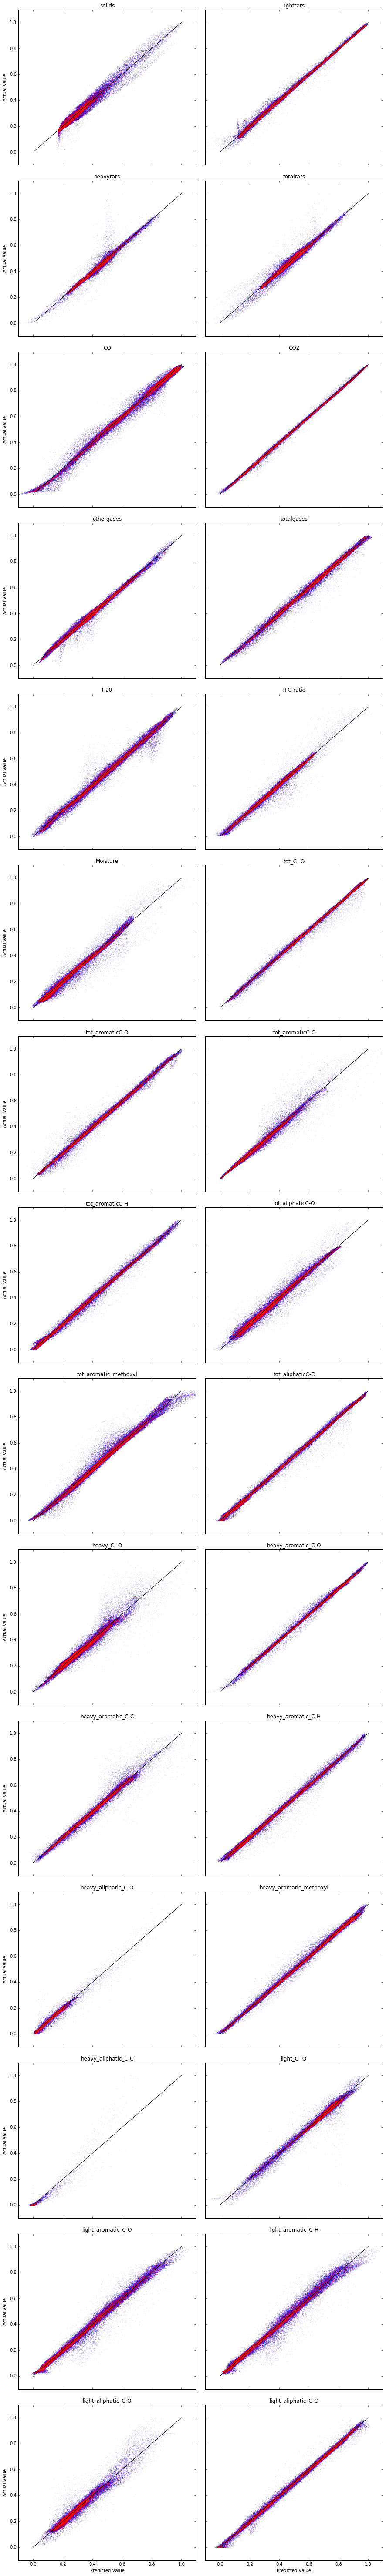

In [12]:
# Parity plots for each network
output_list = net_objs.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=True,
                     sharey=True, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()

for key in net_objs:
    title = y_columns[key]
    net = net_objs[key]
    y_predictions = net.predict(x_train)
    y_predictions_test = net.predict(x_test)
    pplot_one_output(y_predictions, y_predictions_test, key, title)

ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.05)
    

In [13]:
r_squared2 = {}
for key in net_objs:
    net = net_objs[key]
    title = y_columns[key]
    y_predictions = net.predict(x_train)
    r_squared2[title] = r2_score(y_train[:, key], y_predictions[:])
r_squared2

{'CO': 0.9931549818169555,
 'CO2': 0.99908888412289854,
 'H-C-ratio': 0.98937436609537766,
 'H20': 0.99222651908028614,
 'Moisture': 0.98161438185322558,
 'heavy_C--O': 0.96169319394720032,
 'heavy_aliphatic_C-C': 0.92793016293697483,
 'heavy_aliphatic_C-O': 0.97566368021067218,
 'heavy_aromatic_C-C': 0.98579905607064755,
 'heavy_aromatic_C-H': 0.99654989201181154,
 'heavy_aromatic_C-O': 0.99776653497806722,
 'heavy_aromatic_methoxyl': 0.99697604013818319,
 'heavytars': 0.97762402733985954,
 'light_C--O': 0.98635975047879665,
 'light_aliphatic_C-C': 0.99760078267534069,
 'light_aliphatic_C-O': 0.95630015834295601,
 'light_aromatic_C-H': 0.98873695601630907,
 'light_aromatic_C-O': 0.99049610190610538,
 'lighttars': 0.99776872584397636,
 'othergases': 0.99280111514032288,
 'solids': 0.97692156275424058,
 'tot_C--O': 0.99789811561406894,
 'tot_aliphaticC-C': 0.99808325111053575,
 'tot_aliphaticC-O': 0.9842770704965923,
 'tot_aromaticC-C': 0.98328267733525454,
 'tot_aromaticC-H': 0.9965250

In [14]:
keylist = r_squared.keys()
keylist.sort()
print 'Difference in R**2 values\n'
for x in keylist:
    print '%s:%s' % ('{: <28}'.format(x),
                     '{: >10}'.format(round(r_squared2[x] - r_squared[x], 4)))

Difference in R**2 values

CO                          :    0.0059
CO2                         :    0.0008
H-C-ratio                   :    0.0161
H20                         :    0.0065
Moisture                    :    0.0043
heavy_C--O                  :     0.012
heavy_aliphatic_C-C         :    0.4138
heavy_aliphatic_C-O         :    0.0601
heavy_aromatic_C-C          :    0.0195
heavy_aromatic_C-H          :    0.0018
heavy_aromatic_C-O          :    0.0037
heavy_aromatic_methoxyl     :    0.0018
heavytars                   :    0.0276
light_C--O                  :    0.0203
light_aliphatic_C-C         :     0.006
light_aliphatic_C-O         :    0.0405
light_aromatic_C-H          :    0.0016
light_aromatic_C-O          :    0.0026
lighttars                   :     0.003
othergases                  :    0.0059
solids                      :   -0.0016
tot_C--O                    :    0.0043
tot_aliphaticC-C            :    0.0023
tot_aliphaticC-O            :    0.0117
tot_aromaticC

# Next steps & discussion
---
- Experiment with deeper networks or other refinements on some output measures that aren't training as well

- try some experiments with using the standard scaler for the outputs
- try using two hidden layers
- re-run full network with ada_grad
- use a variable learning rate
- try using tanh as the nonlinearity (lecun paper, page 10).  Consider using a custom nonlinearity as in lecun.
- how are the starting weights chosen?


- Is "funny business" from edge cases?
  - suggestions for identifying those points?
  

- How should I treat predictions >1 or <0?


- Benchmarking to compare with solving system of ODEs
  - what exactly to benchmark? modify ODE-based program to calculate same set of SS outputs?
  
  
- We know there is some error; how to describe where that error is and what the impact is on using the model?


- Make a scatterplot matrix of the values of the input parameters that are varied
  
  
- If there is time:
  - try training temporal network by adding time as node in input layer
  - experiment with other regression algorithms from sklearn
    - Jake suggests trying a random forest regressor.  Will need to adjust the max depth parameter
    - also http://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#example-svm-plot-svm-regression-py
  - incorporate this ANN framework into a simple particle model to demonstrate it is possible to include complicated kinetics with transport


In [9]:
NeuralNet()

['/Users/houghb/src/lasagne/lasagne']

In [12]:
temp = net_objs[0]

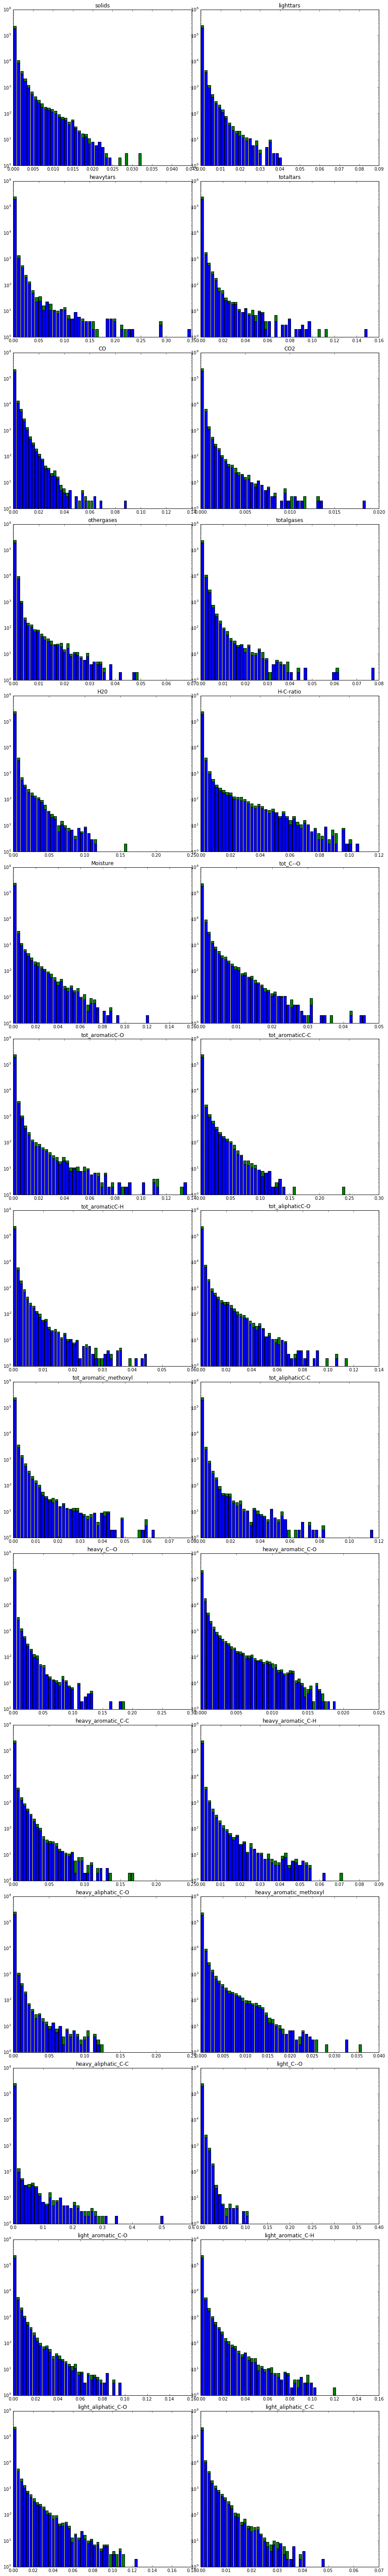

In [63]:
# For complete network
def hplot_one_output(y_train, y_test, y_predictions,
                     y_predictions_test, output_col):
    """
    Make a histogram for the training (blue) and test (green)
    MSEs of a specific output measure.
    
    Parameters
    ----------
    y_train            : numpy ndarray
                         The array with the training set values
    y_test             : numpy ndarray
                         The array with the test set values
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    output_col         : int
                         The column of the output measure you want to plot
    
    Returns
    -------
    None
    """
    train_mse = []
    for i, value in enumerate(y_train[:]):
        train_mse.append(mean_squared_error([y_train[i][output_col]],
                                            [y_predictions[i][output_col]]))

    test_mse = []
    for i, value in enumerate(y_test[:]):
        test_mse.append(mean_squared_error([y_test[i][output_col]],
                                           [y_predictions_test[i][output_col]]))

    ax[output_col].hist([train_mse, test_mse], bins=50, stacked=True,
                        label=['train', 'test'], log=True)
    ax[output_col].set_title('%s' % y_columns[output_col])

y_predictions = comp_net.predict(x_train)
y_predictions_test = comp_net.predict(x_test)
    
output_list = y_columns[:]
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2,
                     figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()
for i, x in enumerate(output_list):
    hplot_one_output(y_train, y_test, y_predictions, y_predictions_test, i)
f.subplots_adjust(hspace=0.1, wspace=0.05)
    

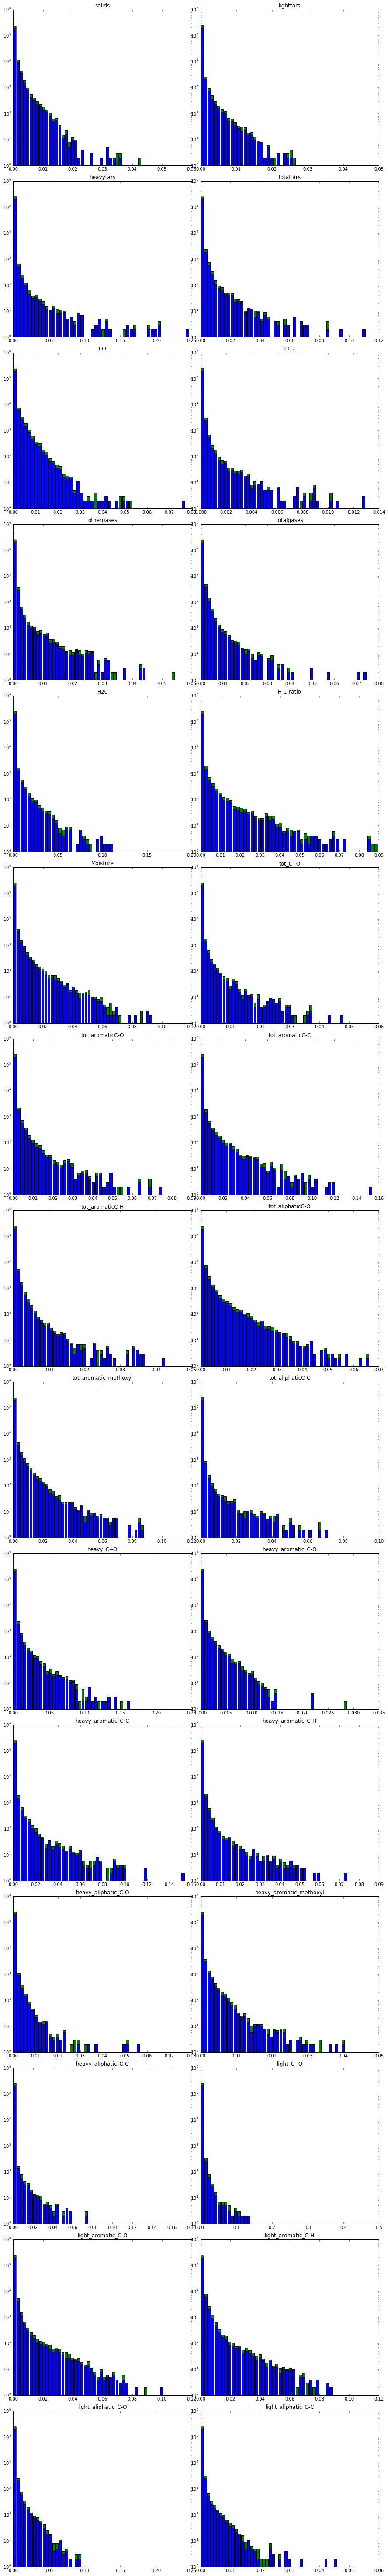

In [64]:
# For 30 independent networks
def hplot_one_output(y_train, y_test, y_predictions,
                     y_predictions_test, output_col):
    """
    Make a histogram for the training (blue) and test (green)
    MSEs of a specific output measure.
    
    Parameters
    ----------
    y_train            : numpy ndarray
                         The array with the training set values
    y_test             : numpy ndarray
                         The array with the test set values
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    output_col         : int
                         The column of the output measure you want to plot
    
    Returns
    -------
    None
    """
    train_mse = []
    for i, value in enumerate(y_train[:]):
        train_mse.append(mean_squared_error([y_train[i][output_col]],
                                            [y_predictions[i]]))

    test_mse = []
    for i, value in enumerate(y_test[:]):
        test_mse.append(mean_squared_error([y_test[i][output_col]],
                                           [y_predictions_test[i]]))

    ax[output_col].hist([train_mse, test_mse], bins=50, stacked=True,
                        label=['train', 'test'], log=True)
    ax[output_col].set_title('%s' % y_columns[output_col])


output_list = net_objs.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2,
                     figsize=(15, 3.5*len(output_list)))

ax = ax.ravel()
for key in net_objs:
    net = net_objs[key]
    y_predictions = net.predict(x_train)
    y_predictions_test = net.predict(x_test)
    hplot_one_output(y_train, y_test, y_predictions, y_predictions_test, key)
f.subplots_adjust(hspace=0.1, wspace=0.05)
    